# **Partie 3 :** Enrichissement des données à l’aide des champs textuels

---


In [1]:
# Imports utiles
from fonctions2 import *
import pandas as pd
import matplotlib.pyplot as plt


c:\Users\elyes\Desktop\MALIA\3-1_DeepLearning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Chargement et préprocessing des données


In [2]:
# Chargement des données
train_df = pd.read_csv("train.csv", sep="\t")
test_df = pd.read_csv("test.csv", sep="\t")


In [3]:
# Définir la colonne qualitative a choisir

target = "playlist_name"
# target = "track_name"


In [4]:
# Extraction des colonnes nécessaires
train_target = train_df[target]
train_genres = train_df["playlist_genre"]

test_target = test_df[target]
test_genres = test_df["playlist_genre"]


In [5]:
# Extraire les genres uniques et créer un mapping genre -> indice
unique_genres = np.unique(train_genres)
genre_to_idx = {g: i for i, g in enumerate(unique_genres)}


In [6]:
# Conversion des genres en indices numériques
y = np.array([genre_to_idx[g] for g in train_genres])
y_test = np.array([genre_to_idx[g] for g in test_genres])


## 2. Encodage des titres en vecteurs numériques avec Sentence-BERT


In [7]:
# Chargement d'un modèle Sentence-BERT pour encoder les titres en vecteurs denses.
text_model = load_text_encoder()

# Encodage des titres d'entraînement et de test en utilisant le modèle chargé.
# Embeddings pour l'ensemble d'entraînement
X_embeddings = encode_titles(text_model, train_target)
# Embeddings pour l'ensemble de test
X_test_embeddings = encode_titles(text_model, test_target)

# Affichage des dimensions des matrices d'embeddings obtenues.
print("Dimensions des embeddings d'entraînement :", X_embeddings.shape)
print("Dimensions des embeddings de test :", X_test_embeddings.shape)


Dimensions des embeddings d'entraînement : (21428, 384)
Dimensions des embeddings de test : (5357, 384)


## 3. Séparation Train/Val

On va créer un ensemble de validation à partir de l'ensemble d'entraînement.


In [8]:
# Mélange aléatoire des données pour éviter tout biais lié à leur ordre initial.
n = len(X_embeddings)  # Nombre total d'exemples
idx = np.arange(n)  # Création d'indices de 0 à n-1
np.random.shuffle(idx)  # Mélange des indices

# Réarrangement des embeddings et des étiquettes selon les indices mélangés.
X_embeddings = X_embeddings[idx]
y = y[idx]


In [9]:
# Définition du ratio d'entraînement et calcul de la taille de l'ensemble d'entraînement.
train_ratio = 0.85  # 85% des données pour l'entraînement
train_size = int(train_ratio * n)  # Nombre d'exemples dans l'ensemble d'entraînement

# Division des données en ensembles d'entraînement et de validation.
X_train = X_embeddings[:train_size]  # Embeddings pour l'entraînement
y_train = y[:train_size]  # Étiquettes correspondantes

X_val = X_embeddings[train_size:]  # Embeddings pour la validation
y_val = y[train_size:]  # Étiquettes correspondantes

# Affichage des tailles des ensembles.
print("Taille Train :", len(X_train), "\nTaille Val :", len(X_val))


Taille Train : 18213 
Taille Val : 3215


## 4. Développement du réseau MLP et entraînement


In [10]:
# Configuration du modèle
input_dim = X_train.shape[1]  # Dimension des embeddings (features)
num_classes = len(unique_genres)  # Nombre de classes de sortie
# Architecture avec deux couches cachées de 512 neurones chacune
layer_sizes = [512, 512]

# Initialisation d'un modèle MLP simple avec les dimensions spécifiées.
model = SimpleMLP(input_dim=input_dim, layer_sizes=layer_sizes, num_classes=num_classes)

# Entraînement du modèle avec les hyperparamètres définis.
history = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=35,  # Nombre d'époques
    batch_size=32,  # Taille des mini-lots
    lr=0.01,  # Taux d'apprentissage
    verbose=True,  # Affichage des métriques par époque
)


Epoch 1/35 - Train Loss: 1.6078, Train Acc: 0.2132, Val Loss: 1.6082, Val Acc: 0.2212
Epoch 2/35 - Train Loss: 1.6074, Train Acc: 0.2132, Val Loss: 1.6080, Val Acc: 0.2212
Epoch 3/35 - Train Loss: 1.6070, Train Acc: 0.2132, Val Loss: 1.6078, Val Acc: 0.2212
Epoch 4/35 - Train Loss: 1.6066, Train Acc: 0.2132, Val Loss: 1.6073, Val Acc: 0.2212
Epoch 5/35 - Train Loss: 1.6060, Train Acc: 0.2132, Val Loss: 1.6068, Val Acc: 0.2212
Epoch 6/35 - Train Loss: 1.6052, Train Acc: 0.2132, Val Loss: 1.6059, Val Acc: 0.2212
Epoch 7/35 - Train Loss: 1.6039, Train Acc: 0.3576, Val Loss: 1.6048, Val Acc: 0.3599
Epoch 8/35 - Train Loss: 1.6019, Train Acc: 0.3683, Val Loss: 1.6029, Val Acc: 0.3677
Epoch 9/35 - Train Loss: 1.5984, Train Acc: 0.3713, Val Loss: 1.5995, Val Acc: 0.3708
Epoch 10/35 - Train Loss: 1.5919, Train Acc: 0.3713, Val Loss: 1.5930, Val Acc: 0.3708
Epoch 11/35 - Train Loss: 1.5784, Train Acc: 0.3830, Val Loss: 1.5798, Val Acc: 0.3792
Epoch 12/35 - Train Loss: 1.5457, Train Acc: 0.3748,

## 5. Visualisation des courbes d'apprentissage


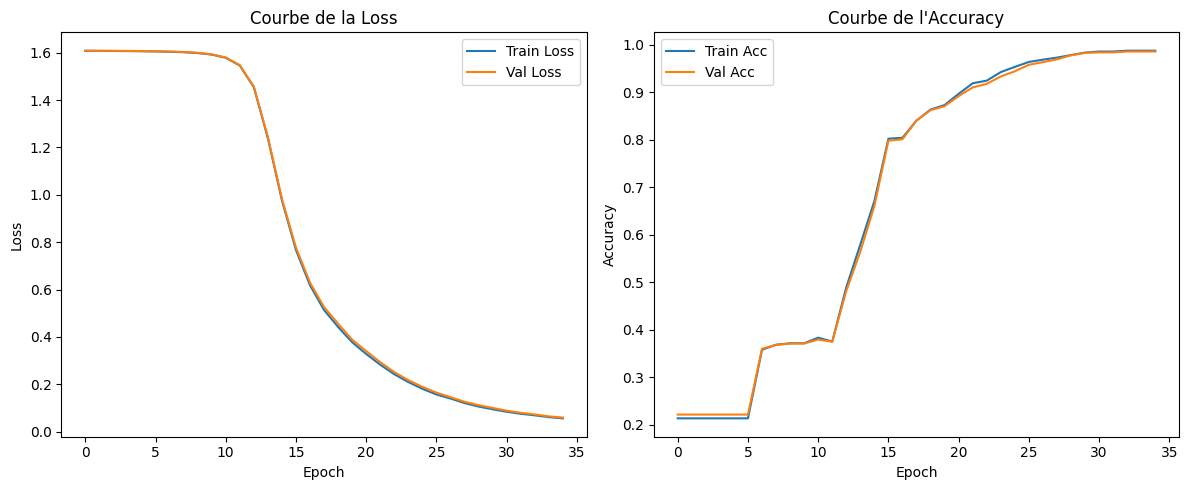

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Courbe de l'Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


## 6. Évaluation sur le test set


In [12]:
# Prédictions sur l'ensemble de test à l'aide du modèle entraîné.
test_preds = model.predict(X_test_embeddings)

# Calcul de la précision sur l'ensemble de test.
test_acc = np.mean(test_preds == y_test)

# Affichage de la précision sous forme fractionnaire et en pourcentage.
print(f"Accuracy sur le test set : {test_acc:.4f} ({test_acc * 100:.2f}%)")


Accuracy sur le test set : 0.9888 (98.88%)


## 7. Combinaison


### Chargement des données

Nous chargeons `train.csv` et `test.csv`. Nous extrayons :

- Les features numériques (définies précédemment : danceability, energy, etc.)
- Les titres (track_name) pour encoder en embeddings textuels
- Les genres (playlist_genre) pour la classification


In [13]:
# Colonnes numériques utilisées précédemment
num_cols = [
    "track_popularity",  # Mesure de la popularité d'une musique
    "danceability",  # Mesure de la capacité à danser (0 à 1)
    "energy",  # Intensité et activité globale de la piste
    "key",  # Tonalité musicale (0 à 11)
    "loudness",  # Niveau sonore moyen en décibels
    "mode",  # Mode (majeur = 1, mineur = 0)
    "speechiness",  # Mesure de la présence de paroles
    "acousticness",  # Probabilité qu'il s'agisse d'une piste acoustique
    "instrumentalness",  # Mesure de l'absence de paroles
    "liveness",  # Probabilité qu'il s'agisse d'un enregistrement live
    "valence",  # Mesure de la positivité musicale (0 à 1)
    "tempo",  # Tempo de la piste en battements par minute (BPM)
    "duration_ms",  # Durée de la piste en millisecondes
]

train_target = train_df[target]
train_genres = train_df["playlist_genre"]
X_num = train_df[num_cols].values

test_target = test_df[target]
test_genres = test_df["playlist_genre"]
X_num_test = test_df[num_cols].values


In [14]:
# Création du mapping genre -> index
unique_genres = np.unique(train_genres)
genre_to_idx = {g: i for i, g in enumerate(unique_genres)}
y = np.array([genre_to_idx[g] for g in train_genres])
y_test = np.array([genre_to_idx[g] for g in test_genres])


### Normalisation des données numériques

Comme précédemment, on calcule la moyenne et l'écart-type sur le train.
Puis on applique la même normalisation sur test.


In [15]:
# Calcul de la moyenne et de l'écart-type des données numériques pour normalisation.
mean = X_num.mean(axis=0)  # Moyenne par colonne (caractéristique)

# Écart-type par colonne, avec petite constante pour éviter division par zéro
std = X_num.std(axis=0) + 1e-9

# Normalisation des données d'entraînement : centrage et réduction.
X_num = (X_num - mean) / std

# Normalisation des données de test en utilisant la moyenne et l'écart-type de l'entraînement.
X_num_test = (X_num_test - mean) / std


### Encodage des titres en embeddings textuels

On utilise Sentence-BERT pour encoder les titres en vecteurs.
On obtient `X_text` et `X_text_test`, que l'on combinera ensuite aux données numériques.


In [16]:
# Chargement du modèle textuel et encodage des titres en vecteurs denses.
text_model = load_text_encoder()

# Embeddings textuels pour l'entraînement
X_text = encode_titles(text_model, train_target)
X_text_test = encode_titles(text_model, test_target)  # Embeddings textuels pour le test

# Affichage des dimensions des embeddings textuels.
print("Dimension des embeddings textuels sur train :", X_text.shape)
print("Dimension des embeddings textuels sur test :", X_text_test.shape)


Dimension des embeddings textuels sur train : (21428, 384)
Dimension des embeddings textuels sur test : (5357, 384)


### Combinaison des données numériques et textuelles

On concatène horizontalement les embeddings textuels et les données numériques.
Ainsi, l'entrée du réseau combinera les deux types d'information.


In [17]:
# Combinaison des embeddings textuels et des données numériques.
# Concaténation côté colonnes pour l'entraînement
X_combined = np.hstack([X_text, X_num])
X_combined_test = np.hstack([X_text_test, X_num_test])  # Idem pour le test

# Affichage des dimensions finales après combinaison.
print("Dimension finale (texte + num) sur train :", X_combined.shape)
print("Dimension finale (texte + num) sur test :", X_combined_test.shape)


Dimension finale (texte + num) sur train : (21428, 397)
Dimension finale (texte + num) sur test : (5357, 397)


### Séparation Train/Val

On crée un ensemble de validation à partir de l'entraînement.


In [18]:
# Mélange aléatoire des données combinées pour éviter tout biais.
n = len(X_combined)  # Nombre total d'exemples
idx = np.arange(n)  # Indices des exemples
np.random.shuffle(idx)  # Mélange des indices

# Réarrangement des données et étiquettes selon les indices mélangés.
X_combined = X_combined[idx]
y = y[idx]

# Division des données en ensembles d'entraînement et de validation.
train_ratio = 0.85  # 85% des données pour l'entraînement
train_size = int(train_ratio * n)  # Taille de l'ensemble d'entraînement

X_train = X_combined[:train_size]  # Données d'entraînement
y_train = y[:train_size]  # Étiquettes d'entraînement

X_val = X_combined[train_size:]  # Données de validation
y_val = y[train_size:]  # Étiquettes de validation

# Affichage des tailles des ensembles d'entraînement et de validation.
print("Taille Train :", len(X_train), "Taille Val :", len(X_val))


Taille Train : 18213 Taille Val : 3215


### Développement du réseau MLP et entraînement

On utilise un réseau similaire, mais maintenant l'entrée est la concaténation des embeddings textuels et numériques.
On peut ajuster la taille du réseau si on veut.


In [19]:
# Configuration du modèle MLP
input_dim = X_train.shape[1]  # Dimension d'entrée (texte + numérique combinés)
num_classes = len(unique_genres)  # Nombre total de classes (genres uniques)

# Architecture avec deux couches cachées de 512 neurones chacune
layer_sizes = [512, 512]

# Initialisation du modèle SimpleMLP avec la configuration définie
model = SimpleMLP(input_dim=input_dim, layer_sizes=layer_sizes, num_classes=num_classes)

# Entraînement du modèle
history = train_model(
    model,
    X_train,  # Données d'entraînement
    y_train,  # Étiquettes d'entraînement
    X_val,  # Données de validation
    y_val,  # Étiquettes de validation
    epochs=35,  # Nombre d'époques
    batch_size=32,  # Taille des mini-lots
    lr=0.01,  # Taux d'apprentissage
    verbose=True,  # Affichage des métriques par époque
)


Epoch 1/35 - Train Loss: 1.6070, Train Acc: 0.2161, Val Loss: 1.6082, Val Acc: 0.2047
Epoch 2/35 - Train Loss: 1.6052, Train Acc: 0.2161, Val Loss: 1.6069, Val Acc: 0.2047
Epoch 3/35 - Train Loss: 1.6019, Train Acc: 0.2161, Val Loss: 1.6037, Val Acc: 0.2047
Epoch 4/35 - Train Loss: 1.5926, Train Acc: 0.2263, Val Loss: 1.5949, Val Acc: 0.2171
Epoch 5/35 - Train Loss: 1.5556, Train Acc: 0.3714, Val Loss: 1.5598, Val Acc: 0.3593
Epoch 6/35 - Train Loss: 1.4189, Train Acc: 0.3953, Val Loss: 1.4313, Val Acc: 0.3785
Epoch 7/35 - Train Loss: 1.3059, Train Acc: 0.4620, Val Loss: 1.3201, Val Acc: 0.4429
Epoch 8/35 - Train Loss: 1.2240, Train Acc: 0.5209, Val Loss: 1.2382, Val Acc: 0.5048
Epoch 9/35 - Train Loss: 1.1195, Train Acc: 0.5783, Val Loss: 1.1344, Val Acc: 0.5611
Epoch 10/35 - Train Loss: 0.9853, Train Acc: 0.6560, Val Loss: 1.0006, Val Acc: 0.6463
Epoch 11/35 - Train Loss: 0.8332, Train Acc: 0.7438, Val Loss: 0.8481, Val Acc: 0.7362
Epoch 12/35 - Train Loss: 0.6835, Train Acc: 0.7993,

### Visualisation des courbes d'apprentissage


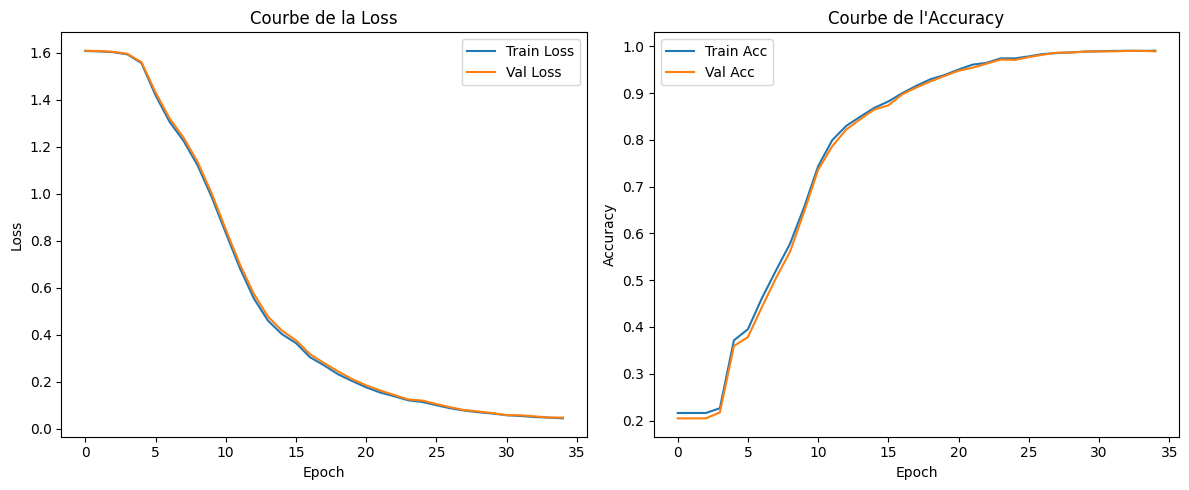

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de la Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Courbe de l'Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Évaluation finale sur le test set

On évalue maintenant les performances du modèle sur le test set combiné.


In [21]:
# Évaluation sur le test set
# Prédictions sur les données combinées de test
test_preds = model.predict(X_combined_test)
test_acc = np.mean(test_preds == y_test)  # Calcul de la précision sur le test set

# Affichage des résultats finaux
print(
    f"Accuracy sur le test set (combinaison texte + num) : {test_acc:.4f} ({test_acc*100:.2f}%)"
)


Accuracy sur le test set (combinaison texte + num) : 0.9897 (98.97%)


In [22]:
# Création d'un nouveau CSV avec les prédictions du modèle

# Prédiction des classes sur le test set combiné
final_preds = model.predict(X_combined_test)

# Inverse mapping des indices vers les genres
idx_to_genre = {v: k for k, v in genre_to_idx.items()}
final_pred_genres = [idx_to_genre[idx] for idx in final_preds]

# Création d'une copie du test_df
prediction_df = test_df.copy()

# Remplacement de la colonne "playlist_genre" par les prédictions
prediction_df["playlist_genre"] = final_pred_genres

# Sauvegarde du nouveau CSV avec les prédictions
prediction_df.to_csv("KHALFALLAH_ACHATOUI_prediction_full.csv", sep="\t", index=False)
print(
    "Fichier 'KHALFALLAH_ACHATOUI_prediction_full.csv' créé/modifié avec les prédictions."
)


Fichier 'KHALFALLAH_ACHATOUI_prediction_full.csv' créé/modifié avec les prédictions.
